# ChatGPT Sentiment Analysis of Facebook Group Comments

# 1. Objective
Engaging with the public through social media is important to the success of many online businesses. While social media makes it easier than ever for the public to engage with businesses, small business owners already have a lot on their plate outside of responding to social media queries and comments. While analyzing written text can be automated through machine learning, this traditionally requires extensive resources that most individuals and small businesses do not have. 

ChatGPT can classify natural language data, a task that has traditionally required the the training and deployment of machine learning models.

The goal of this project is to **determine how well ChatGPT performs at text classification**. Specifically, I wanted to conceptually show whether **ChatGPT can improve the workflow of small businesses** that use social media. 

Here are the three tasks I asked ChatGPT to perform using comments posts in a Facebook group:
1. `sentiment`: Label the sentiment as "positive", "neutral", or "negative".
2. `emotion`: Identify the main emotion.
3. `respond`: Recommend whether or not the Facebook group administrator/business owner should quickly respond to the comment.


# 2. Methods

This project used the following:
* [Facebook Graph API](https://developers.facebook.com/docs/graph-api/reference)
* [LangChain](https://api.python.langchain.com/en/latest/api_reference.html#), which uses the [OpenAI API](https://platform.openai.com/overview)
* `scikit-learn` and `pandas`
* Jupyter Notebook extension in VSCode

## Step 1: Get Data from Facebook Group Posts

I retrieved the 30 most recent posts from a Facebook group associated with a an online personal training business (I have permission from the group administrator). This data included all the posts' comments (64 total top-level comments) and the replies to these comments. 

In [3]:
import pandas as pd
import sys
sys.path.append(r"C:\Users\silvh\OneDrive\lighthouse\custom_python")
from silvhua import *
# set the option to wrap text within cells
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [ ]:
import json
import requests

with open("../online-PT-social-media-NLP/notebooks/credentials.json") as f:
    credentials = json.load(f)

ig_user_id = credentials['am_ig_user_id']
access_token = credentials['am_fb_access_token']
group_id = credentials['SSC_group_id']

posts_data_dict = dict()
posts_df_dict = dict()
comments_response_dict = dict()
comments_df_dict = dict()
replies_dict = dict()

def get_facebook_posts(group_id, access_token, limit=30):
    """
    Makes a GET request to pull posts from a Facebook group using the Facebook API.
    Outputs the results into a DataFrame so that each post is a row along with its time stamp, message,
    permalink, comments count, reactions, and post ID.
    Also outputs the response.json().

    Parameters:
        group_id (str): The ID of the Facebook group to pull posts from.
        access_token (str): An access token with the appropriate permissions to access the group's content.
        limit (int): The number of posts to retrieve (default is 100).

    Returns:
        pandas.DataFrame: A DataFrame containing the posts and their associated data.
    """
    url = f"https://graph.facebook.com/{group_id}/feed"

    params = {
        "access_token": access_token,
        "fields": "created_time,message,permalink_url,comments.limit(10).summary(true),reactions.limit(500).summary(true).type(LIKE).as(like),reactions.limit(500).summary(true).type(LOVE).as(love),reactions.limit(500).summary(true).type(WOW).as(wow),reactions.limit(500).summary(true).type(HAHA).as(haha),reactions.limit(500).summary(true).type(SAD).as(sad),reactions.limit(500).summary(true).type(ANGRY).as(angry)",
        "limit": limit
    }
    response = requests.get(url, params=params)
    status_code = response.status_code
    print("Response Status Code:", status_code)
    data = response.json()
    return data

## I will use this as part of the final code for the task
def process_response(data):
    posts = []
    comments = []
    for post in data["data"]:
        created_time = post.get("created_time")
        message = post.get("message")
        permalink_url = post.get("permalink_url")
        comments_count = post.get("comments", {}).get("summary", {}).get("total_count", 0)
        reactions = post.get("like", {}).get("summary", {}).get("total_count", 0), post.get("love", {}).get("summary", {}).get("total_count", 0), post.get("wow", {}).get("summary", {}).get("total_count", 0), post.get("haha", {}).get("summary", {}).get("total_count", 0), post.get("sad", {}).get("summary", {}).get("total_count", 0), post.get("angry", {}).get("summary", {}).get("total_count", 0)
        post_id = post.get("id")
        posts.append({
            "post_id": post_id,
            "created_time": created_time,
            "message": message,
            "comments_count": comments_count,
            "like_count": reactions[0],
            "love_count": reactions[1],
            "wow_count": reactions[2],
            "haha_count": reactions[3],
            "sad_count": reactions[4],
            "angry_count": reactions[5],
            "permalink_url": permalink_url,
        })

    df = pd.DataFrame(posts)
    # Reorder columns
    df = df[["post_id", "created_time", "message", "comments_count", "like_count", "love_count", "wow_count", "haha_count", "sad_count", "angry_count", "permalink_url"]]
    
    return df

def get_fb_comments(group_id, access_token, limit=30):
    """
    Pulls comments from a Facebook group using the Facebook API and outputs the results into a pandas DataFrame.
    
    Parameters:
    group_id (str): The ID of the Facebook group to pull comments from.
    access_token (str): A Facebook access token with the necessary permissions to access the group.
    
    Returns:
    Tuple(pandas.DataFrame, dict): A tuple containing a DataFrame with each comment as a row along with its details and replies,
    and the full JSON response from the API.
    """
    # Set up the API endpoint and parameters
    url = f"https://graph.facebook.com/{group_id}/feed"
    params = {
        "fields": "comments{created_time,message,from,comments{created_time,message,from}}",
        "access_token": access_token,
        "limit": limit
    }

    # Make the GET request
    response = requests.get(url, params=params)
    
    # Convert the response to a DataFrame
    comments = []
    for post in response.json()["data"]:
        post_comments = post.get("comments", {}).get("data", [])
        for comment in post_comments:
            comment_dict = {
                "post_id": post.get("id"),
                "created_time": comment.get("created_time"),
                "message": comment.get("message"),
                "author_id": comment.get("from", {}).get("id"),
                "author_name": comment.get("from", {}).get("name"),
                "parent_id": None,
                "parent_name": None,
            }
            parent_comment = comment.get("comments", {}).get("data", [])
            if parent_comment:
                parent_comment = parent_comment[0]
                comment_dict["parent_id"] = parent_comment.get("id")
                comment_dict["parent_name"] = parent_comment.get("from", {}).get("name")
            comments.append(comment_dict)
    df = pd.DataFrame(comments)
    return df, response.json()

def create_reply_dataframe(json_object, add_replies=False):
    # Initialize empty lists to store data
    post_id_list = []
    parent_comment_message_list = []
    comment_id_list = []
    reply_comment_message_list = []
    reply_created_time_list = []
    reply_id_list = []
    
    # Loop through each post in the json object
    for post in json_object:
        # Get the post ID
        post_id = post['id']
        
        try: # SH 2023-03-22 10:50 Added this 
            # Loop through each comment in the post
            for comment in post['comments']['data']:
                # Get the comment ID and message
                comment_id = comment['id']
                parent_comment_message = comment['message']
                
                # Check if the comment has any replies
                if add_replies == True:
                    # Loop through each reply to the comment
                    for reply in comment['comments']['data']:
                        if 'comments' in comment:
                            # Get the reply ID, message, and creation time
                            reply_id = reply['id']
                            reply_comment_message = reply['message']
                            reply_created_time = reply['created_time']
                            
                            # Add the data to the lists
                            post_id_list.append(post_id)
                            parent_comment_message_list.append(parent_comment_message)
                            comment_id_list.append(comment_id)
                            reply_comment_message_list.append(reply_comment_message)
                            reply_created_time_list.append(reply_created_time)
                            reply_id_list.append(reply_id)
                else:
                    # Add the data to the lists
                    post_id_list.append(post_id)
                    parent_comment_message_list.append(parent_comment_message)
                    comment_id_list.append(comment_id)
        except Exception  as error:
            # exc_type, exc_obj, tb = sys.exc_info()
            # f = tb.tb_frame
            # lineno = tb.tb_lineno
            # filename = f.f_code.co_filename
            # print("An error occurred on line", lineno, "in", filename, ":", error)
            pass
    
    # Create a dataframe from the lists
    if add_replies == True:
        df = pd.DataFrame({
            'post_id': post_id_list,
            'parent_comment_message': parent_comment_message_list,
            'comment_id': comment_id_list,
            'reply_comment_message': reply_comment_message_list,
            'reply_created_time': reply_created_time_list,
            'reply_id': reply_id_list
        })
    else:
        df = pd.DataFrame({
            'post_id': post_id_list,
            'parent_comment_message': parent_comment_message_list,
            'comment_id': comment_id_list,
        })
    return df

def merge_dataframes(comments_df, posts_df, replies_df, add_replies=False):
    # merge comments and posts dataframes on post_id
    merged_df = pd.merge(comments_df, posts_df, on='post_id', how='outer')
    # merge replies dataframe on comment_id
    merged_df = pd.merge(merged_df, replies_df, left_on='message_x', right_on='parent_comment_message', how='left')
    if add_replies == True:
        # rename columns
        merged_df = merged_df.rename(columns={
            'post_id_x': 'post_id',
            'created_time_x': 'comment_created_time',
            'created_time_y': 'post_created_time',
            'message_x': 'comment_message',
            'message_y': 'post_message',
            'parent_name_x': 'parent_name',
            'reply_comment_message': 'reply_message',
            'reply_created_time': 'reply_created_time',
            'reply_id': 'reply_id'
        })
        # drop unnecessary columns
        merged_df = merged_df.drop(columns=['parent_name', 'parent_id'])
        # reorder columns
        merged_df = merged_df[['post_id', 'post_message', 'post_created_time', 'comment_created_time', 'parent_comment_message',
                            'comment_id', 'reply_message', 'reply_created_time', 'reply_id']]
    else:
        # rename columns
        merged_df = merged_df.rename(columns={
            'post_id_x': 'post_id',
            'created_time_x': 'comment_created_time',
            'created_time_y': 'post_created_time',
            'message_x': 'comment_message',
            'message_y': 'post_message',
            'parent_name_x': 'parent_name',
        })
        # drop unnecessary columns
        merged_df = merged_df.drop(columns=['parent_name', 'parent_id'])
        # reorder columns
        merged_df = merged_df[['post_id', 'post_message', 'post_created_time', 'comment_created_time', 'parent_comment_message',
                            'comment_id']]
    return merged_df

def process_posts(df):
    """
    Return the unique non-null parent_comment_message values and the associated post_message values.
    """
    df = df[['parent_comment_message', 'post_message']].drop_duplicates()
    df = df[df['parent_comment_message'].notnull()]
    df = df[df['post_message'].notnull()]
    results = pd.DataFrame(
        df.apply(lambda row: f"You: {row['post_message']}\n\nMember: {row['parent_comment_message']}", axis=1).unique(),
        columns=['text'])
    return results


iteration = 1.11

# Get Facebook group posts
posts_data_dict[iteration] = get_facebook_posts(group_id, access_token)
posts_df_dict[iteration] = process_response(posts_data_dict[iteration])
comments_df_dict[iteration], comments_response_dict[iteration] = get_fb_comments(group_id, access_token)
replies_dict[iteration] = create_reply_dataframe(comments_response_dict[iteration]['data'], add_replies=0)
merged = merge_dataframes(comments_df_dict[iteration], posts_df_dict[iteration], replies_dict[iteration])


In [14]:
"""
Each row in this dataframe contains one comment (`parent_comment_message`) to a post (`post_message`). 
Some posts are repeated because they have multiple comments.
"""
merged

,post_id,post_message,post_created_time,comment_created_time,parent_comment_message,comment_id
0,2139238999669147_3433340976925603,Greetings team from Airlie Beach 👋\n\nReminder there will be no weekly live training next week as I am on holidays 🙏\n\nI’m curious - have you any holidays planned this year?,2023-06-25T05:50:18+0000,2023-06-25T06:33:26+0000,Yes 😁,3433357203590647
1,2139238999669147_3433340976925603,Greetings team from Airlie Beach 👋\n\nReminder there will be no weekly live training next week as I am on holidays 🙏\n\nI’m curious - have you any holidays planned this year?,2023-06-25T05:50:18+0000,2023-06-25T11:37:43+0000,I’m in Airlie beach too!!,3433488186910882
2,2139238999669147_3433340976925603,Greetings team from Airlie Beach 👋\n\nReminder there will be no weekly live training next week as I am on holidays 🙏\n\nI’m curious - have you any holidays planned this year?,2023-06-25T05:50:18+0000,2023-06-25T22:36:44+0000,You are less than 2 hours away from where I am thats so cool I love airlie beach just never find the time to go there anymore,3433796753546692
3,2139238999669147_3432149000378134,How I stay bikini confident year round 👙\n\nFirst off I need to tell you - being bikini confident has actually NOTHING to do with how you look and everything to do with how you feel.\n\nSo let me ...,2023-06-23T06:46:23+0000,2023-06-23T07:01:32+0000,…. And you look awesome 👏👏,3432154477044253
4,2139238999669147_3432149000378134,How I stay bikini confident year round 👙\n\nFirst off I need to tell you - being bikini confident has actually NOTHING to do with how you look and everything to do with how you feel.\n\nSo let me ...,2023-06-23T06:46:23+0000,2023-06-23T09:39:41+0000,"Mind set is everything! Recently in Thailand, our last day. 12 hrs to kill before the flight, wanted to go for a swim, but didn’t want our baggage to weigh over the 25kg with wet swimmers (LOTS of...",3432216450371389
...,...,...,...,...,...,...
74,2139238999669147_3426735054252862,If you want to start seeing long term results - we need to stop focusing on exercise on a way to ‘burn calories’. Exercise will only ever contribute to a SMALL a...,2023-06-14T20:48:08+0000,NaN,NaN,NaN
75,2139238999669147_3425629184363449,Sarah - Nurse - 29 - Roscommon\n\n‘Before signing up to Amanda’s Strong and Sassy programme - I had attempted to write to Amanda numerous times but deleted the message’\n\n‘Don’t wait as long as I...,2023-06-13T06:42:27+0000,NaN,NaN,NaN
76,2139238999669147_3422437144682653,How to win the weekend 🏆Tag someone who needs to hear this 👌#nutrition #nutritiongoals #onlinecoach #fitness #fitnesscoach #realresults #realnutrition #explore #explorepage,2023-06-08T20:49:45+0000,NaN,NaN,NaN
77,2139238999669147_3419678831625151,"Perfectionist ladies, it's time to ditch the all-or-nothing mentality and adopt a sustainable approach to fitness that brings lasting transformation. I was once...",2023-06-04T20:59:32+0000,NaN,NaN,NaN


In [24]:
print(f"Number of unique posts: {len(merged['post_id'].unique())}")
print(f"Number of unique top-level comments: {len(merged['comment_id'].unique())}")

Number of unique posts: 30
Number of unique top-level comments: 64


## Step 2: Selecting a Subset of Comments for Analysis
To limit the sample size for this mini experiment, I picked the longest comment for each post to include in analysis. Because not every post had comments, this left me with 19 comments to analyze.

In [ ]:
def process_posts(df_raw):
    """
    Return the unique non-null parent_comment_message values and the associated post_message values.
    """
    df = df_raw.copy()
    df = df[['parent_comment_message', 'post_message']].drop_duplicates()
    df = df[df['parent_comment_message'].notnull()]
    df = df[df['post_message'].notnull()]

    # Sort the dataframe by 'post_message' length in descending order
    df.sort_values(by='parent_comment_message', key=lambda x: x.str.len(), ascending=False, inplace=True)
    df.drop_duplicates(subset='post_message', keep='first', inplace=True)

    results = pd.DataFrame(
        df.apply(lambda row: f"YOU: {row['post_message']}\n\nMEMBER: {row['parent_comment_message']}", axis=1).unique(),
        columns=['text'])
    
    results['text'] = results['text'].str.replace('Amanda', 'Amy')
    results['text'] = results['text'].str.replace('amanda', 'amy')
    print(f'Shape of processed DataFrame containing Facebook group posts and comments: {results.shape}')
    return results

input_df = process_posts(merged)
input_df


Shape of processed DataFrame containing Facebook group posts and comments: (19, 1)


,text
0,"You: How I stay bikini confident year round 👙\n\nFirst off I need to tell you - being bikini confident has actually NOTHING to do with how you look and everything to do with how you feel.\n\nSo let me tell you a little story…\n\nOnce upon a time I was a self conscious, controlling perfectionist who believed that being skinny and lean would make me happy. \n\nI thought having abs and being lean were the definition of the perfect body.\n\nAnd I embarked on a journey to achieve ‘perfection’.\n\nI ended up exhausted, overwhelmed and disappointed 😔 \n\nI was unhappy - in a lot of elements of my life - so I decided to seek the help of a life coach. This was hard for me - as I’m a very strong independent woman so asking for help wasn’t easy. But let me tell you - hands down this changed my life.\n\nAfter a very difficult time in my life, I chose to work with a counsellor (for a TOTALLY different reason). \n\nSo what has this got to do with me being happy in a bikini? 🤣\n\nSeeking help from these people - changed my whole outlook on life. They helped me look internally and forced me to uncover some things I didn’t even know about myself. \n\nMy mindset towards myself changed. I stopped focusing on aesthetics as a goal and started working on performance. My relationship with food did a 360 and I started viewing food as fuel instead of calories in versus calories out. I started practising gratitude and meditating. I prioritised sleep instead of ‘grinding’. \n\nAnd (for anyone who read the whole copy) that is how I am now bikini confident year round 👙\n\nMember: Mind set is everything! Recently in Thailand, our last day. 12 hrs to kill before the flight, wanted to go for a swim, but didn’t want our baggage to weigh over the 25kg with wet swimmers (LOTS of shopping was done lol) so my friend and I stripped off to our bra and undies walked the 5 metres across the decking and went swimming! 😂🤣 12 mths ago before meeting u, I would never have dreamed of doing this 🤣😂🤣 you only have one body, just learn to love it! ❤️\nPS you look flipping amazballz!"
1,"You: Do it for you ❤️There will always be critics - silence them ✌️#beunapologeticallyyou\n\nMember: This comment makes me want to throat 👊🏻👊🏻👊🏻👊🏻\nI’m so glad you have broad shoulders, cause I think you look AMAZBALLZ!! I’d love to have a figure like yours, but I’m a wee bit busy, so I’ll settle for the one you helped me get!! ❤️😉 If someone is doing things to please another, what a shallow life they live! Love your response stay positive and keep smiling that gorgeous smile of yours! 💪🏻❤️🦵🏻"
2,"You: Hey @everyone Throw me some questions for our live training tomorrow? Nutrition, exercise, weight loss etc. anything you need to know - that’s what I’m here for\n\nMember: Need some tips for tightening tummy … lost 7kg in 3 months but now got stuck in same weight for more than 2 weeks … what do I need to change??"
3,You: @everyone can you please send me some questions for our live training Thursday! Last weeks questions were great! Remember I’m trying to help you all as much as possible so use this opportunity 👌\n\nMember: Did my measurements today and although my chest and hips seem to be coming down my stomach seems to be going up 😳 what am I doing wrong.
4,"You: Menopause - weights or cardio, 3 sessions a week - what to do, macros and calories - what changes, measurements\n\nMember: Thanks a million. You covered my question perfectly. I couldn't care less about calories but am trying to get the old bod healthy 🙂"
5,You: Greetings team from Airlie Beach 👋\n\nReminder there will be no weekly live training next week as I am on holidays 🙏\n\nI’m curious - have you any holidays planned this year?\n\nMember: You are less than 2 hours away from where I am thats so cool I love airlie beach just never find the time to go there anymore
6,"You: ‘I’ll never get results like her’\n\nDo you find yourself thinking or saying that? If you do - you’re not alone!!!!\n\nThis is something I hear REGULARL

## Step 3. Seek ChatGPT's Wisdom using LangChain
`LangChain` provides libraries that facilitate use of the ChatGPT API. One useful tool is their prompt templates, which allow you to easily swap out one part of the prompt (e.g. the text to analyze, as indicated by `{}`) while keeping the main instructions constant. 

Here are the prompt templates I used to generate my final responses:

Task | Prompt Template
--- | ---
sentiment | You are the owner of a personal training business. You use a Facebook group to as a lead generation tool. You write posts in the group to engage with members and position yourself as a coach who can help them achieve their fitness goals. You aim to respond quickly to comments by group members if they request information, express a desire to improve their fitness, have health conditions or injuries, or express dissatisfaction with their current fitness. Below, delimited by triple back ticks, is a post you wrote in the group and a comment from a member:, Determine the sentiment of the member comment as "positive", "neutral", or "negative". ```{text}``` If you are not sure of the answer, return "?"
emotion | You are the owner of a personal training business. You use a Facebook group to as a lead generation tool. You write posts in the group to engage with members and position yourself as a coach who can help them achieve their fitness goals. You aim to respond quickly to comments by group members if they request information, express a desire to improve their fitness, have health conditions or injuries, or express dissatisfaction with their current fitness. Below, delimited by triple back ticks, is a post you wrote in the group and a comment from a member:, Determine the main emotion expressed in the member comment. Return your response as a single word. ```{text}``` If you are not sure of the answer, return "?"
respond | You are the owner of a personal training business. You use a Facebook group to as a lead generation tool. You write posts in the group to engage with members and position yourself as a coach who can help them achieve their fitness goals. You aim to respond quickly to comments by group members if they request information, express a desire to improve their fitness, have health conditions or injuries, or express dissatisfaction with their current fitness. Below, delimited by triple back ticks, is a post you wrote in the group and a comment from a member:, Indicate whether you need to quickly respond to the message or not using "yes" or "no". ```{text}``` If you are not sure of the answer, return "?"

In [ ]:
from langchain.llms import OpenAI
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.chains import SequentialChain
import os
os.getenv('OPENAI_API_KEY')

def create_LLMChain(template, input_variables, output_key, llm=OpenAI(temperature=0, max_tokens=100)):
    """
    Create an LLMChain object.
    Parameters:
        - template (str): The template for the prompt, i.e. the value of the `template` 
            parameter in the PromptTemplate class.
        - input_variables (List[str]) 
        - output_key (str): The key of the output variable.
        - llm (OpenAI object): Default is OpenAI()

    Returns:
        - LLMChain object
    """
    prompt_template = PromptTemplate(
        template=template, input_variables=input_variables)
    chain = LLMChain(
        llm=llm, prompt=prompt_template, output_key=output_key)
    return chain, prompt_template.template

def analyze_text_sentiment(text, llm=OpenAI(temperature=0, max_tokens=200)):
    """
    Analyze the sentiment of a text.
    Parameters:
        - text (str): The text to analyze.
        - llm (OpenAI object): Default is OpenAI()

    Returns:
        - sentiment (str): The sentiment of the text.
    """
    
    # openai.api_key = os.getenv('api_openai_p')
    template_root = """
    You are the owner of a personal training business. You use a Facebook group to as a lead generation tool.
    You write posts in the group to engage with members and position yourself as \
    a coach who can help them achieve their fitness goals.
    You aim to respond quickly to comments by group members if they request information, \
    express a desire to improve their fitness, have health conditions or injuries, \
    or express dissatisfaction with their current fitness.
    Below, delimited by triple back ticks, is a post you wrote in the group and a comment from a member:, 
    """
    templates = {
        'sentiment': 'Determine the sentiment of the member comment as "positive", "neutral", or "negative".',
        'emotions': 'Determine the main emotion expressed in the member comment. Return your response as a single word.',
        'respond': 'Indicate whether you need to quickly respond to the message or not using "yes" or "no".',
    }
    template_end = 'If you are not sure of the answer, return "?"'
    chain_dict = {}
    prompt_dict = {}
    for template in templates:
        chain_dict[template], prompt_dict[template] = create_LLMChain(
            template_root+templates[template]+' ```{text}``` '+template_end, 
            input_variables=['text'], output_key=template,
            llm=llm)
    overall_chain = SequentialChain(
        chains = [chain for chain in chain_dict.values()], 
        input_variables = ['text' for chain in chain_dict.values()],
        output_variables = list(chain_dict.keys()), verbose=True
    )
    response_dict = overall_chain(text)
    return response_dict, prompt_dict

def batch_analyze_text_sentiment_from_df(messages_df, key='text'):
    response_dict = dict()
    prompt_dict = dict()
    messages_list = messages_df[key].tolist()
    failures = 0
    for iteration_id, message in enumerate(messages_list):
        # print(iteration_id, message)
        try:
            response_dict[iteration_id], prompt_dict[iteration_id] = analyze_text_sentiment(message)
        except Exception as error:
            exc_type, exc_obj, tb = sys.exc_info()
            f = tb.tb_frame
            lineno = tb.tb_lineno
            file = f.f_code.co_filename
            print("An error occurred on line", lineno, "in", file, ":", error)
            print('\t...Error making chatbot request')
            failures += 1
            if failures > 2:
                print('\t...Too many failures, stopping')
                break
    return response_dict, prompt_dict

def create_df_from_response(response):
    """
    Convert the response into a dataframe and strip white spaces at the start and end of text.
    """
    df = pd.DataFrame(response).transpose()
    for column in df.columns:
        df[column] = df[column].str.strip().str.replace('\n', ' ')
        df[column] = df[column].str.strip().str.replace('YOU:', '[YOU]')
        df[column] = df[column].str.strip().str.replace('MEMBER:', '[MEMBER]')
    return df

prompt_dict = dict()
message_dict = dict()
response_dict = dict()

iteration_id = 2

response_dict[iteration_id], prompt_dict[iteration_id] = batch_analyze_text_sentiment_from_df(input_df)

Shape of processed DataFrame containing Facebook group posts and comments: (19, 1)


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


# 3. Results

This table shows:
* `text`: The input data, i.e. the caption of the Facebook group post (preceded by [YOU]) and the comment from a group member (preceeded by [MEMBER]).
* `sentiment`, `emotions`, and `respond`: ChatGPT's responses to the corresponding task prompt.

In [20]:
# Load previously pickled object
path = r'C:\Users\silvh\OneDrive\lighthouse\portfolio-projects\ChatGPT-sentiment-analysis\outputs\raw\2023-07-01'
iteration = 2
prompt_dict = loadpickle('prompt_dict_2023-07-02_1903.sav', path)
response_dict = loadpickle('response_dict_2023-07-02_1903.sav', path)

	Time completed: 2023-07-04 22:50:38.232445
Dictionary keys: [1.1, 1.2, 2]
	Time completed: 2023-07-04 22:50:38.239005
Dictionary keys: [1.1, 1.2, 2]


## ChatGPT's Responses

Here are ChatGPT's responses:

In [ ]:

results_dict = {iteration: create_df_from_response(response_dict[iteration])}
results_dict[iteration]

,text,sentiment,emotions,respond
0,"[YOU] How I stay bikini confident year round 👙 First off I need to tell you - being bikini confident has actually NOTHING to do with how you look and everything to do with how you feel. So let me tell you a little story… Once upon a time I was a self conscious, controlling perfectionist who believed that being skinny and lean would make me happy. I thought having abs and being lean were the definition of the perfect body. And I embarked on a journey to achieve ‘perfection’. I ended up exhausted, overwhelmed and disappointed 😔 I was unhappy - in a lot of elements of my life - so I decided to seek the help of a life coach. This was hard for me - as I’m a very strong independent woman so asking for help wasn’t easy. But let me tell you - hands down this changed my life. After a very difficult time in my life, I chose to work with a counsellor (for a TOTALLY different reason). So what has this got to do with me being happy in a bikini? 🤣 Seeking help from these people - changed my whole outlook on life. They helped me look internally and forced me to uncover some things I didn’t even know about myself. My mindset towards myself changed. I stopped focusing on aesthetics as a goal and started working on performance. My relationship with food did a 360 and I started viewing food as fuel instead of calories in versus calories out. I started practising gratitude and meditating. I prioritised sleep instead of ‘grinding’. And (for anyone who read the whole copy) that is how I am now bikini confident year round 👙 [MEMBER] Mind set is everything! Recently in Thailand, our last day. 12 hrs to kill before the flight, wanted to go for a swim, but didn’t want our baggage to weigh over the 25kg with wet swimmers (LOTS of shopping was done lol) so my friend and I stripped off to our bra and undies walked the 5 metres across the decking and went swimming! 😂🤣 12 mths ago before meeting u, I would never have dreamed of doing this 🤣😂🤣 you only have one body, just learn to love it! ❤️ PS you look flipping amazballz!",Positive,Empathy,No
1,"[YOU] Do it for you ❤️There will always be critics - silence them ✌️#beunapologeticallyyou [MEMBER] This comment makes me want to throat 👊🏻👊🏻👊🏻👊🏻 I’m so glad you have broad shoulders, cause I think you look AMAZBALLZ!! I’d love to have a figure like yours, but I’m a wee bit busy, so I’ll settle for the one you helped me get!! ❤️😉 If someone is doing things to please another, what a shallow life they live! Love your response stay positive and keep smiling that gorgeous smile of yours! 💪🏻❤️🦵🏻",Positive,Encouragement,No
2,"[YOU] Hey @everyone Throw me some questions for our live training tomorrow? Nutrition, exercise, weight loss etc. anything you need to know - that’s what I’m here for [MEMBER] Need some tips for tightening tummy … lost 7kg in 3 months but now got stuck in same weight for more than 2 weeks … what do I need to change??",Positive,Desire,Yes
3,[YOU] @everyone can you please send me some questions for our live training Thursday! Last weeks questions were great! Remember I’m trying to help you all as much as possible so use this opportunity 👌 [MEMBER] Did my measurements today and although my chest and hips seem to be coming down my stomach seems to be going up 😳 what am I doing wrong.,Positive,Frustration,Yes
4,"[YOU] Menopause - weights or cardio, 3 sessions a week - what to do, macros and calories - what changes, measurements [MEMBER] Thanks a million. You covered my question perfectly. I couldn't care less about calories but am trying to get the old bod healthy 🙂",Positive,Thanks,No
5,[YOU] Greetings team from Airlie Beach 👋 Reminder there will be no weekly live training next week as I am on holidays 🙏 I’m curious - have you any holidays planned this year? [MEMBER] You are less than 2 hours away from where I am thats so cool I love airlie beach just never find the time to go there anymore,Positive,Disappointment,No
6,"[YOU] ‘I’ll never get results like her’ Do you f

## Compare My Answers with ChatGPT's 

At first glance, ChatGPT's responses looked pretty good. To quantify ChatGPT's accuracy at the task on hand, we need to know "ground truth"; thus:
* I labelled each post-comment pair myself for the "sentiment" and "respond" tasks (the "emotion task" is too open-ended). 
* I did a simple exploratory data analysis to look at the class distributions of these ground-truth labels.
* I used `scikit-learn` to determine ChatGPT's accuracy and produce a confusion matrix for each of the 2 tasks.

In [4]:
### Is the sentiment positive, negative, or neutral?
sentiment_hl_dict = pd.Series({
    0: 1,
    1: 1,
    2: -1,
    3: -1,
    4: 1,
    5: 1,
    6: 0,
    7: -1,
    8: 0,
    9: 1,
    10: 1,
    11: 1,
    12: 1,
    13: 0,
    14: 1,
    15: 1,
    16: 1,
    17: 1,
    18: 0
})
### Does the comment require a fast reply?
respond_hl_dict = pd.Series({
    0: 0,
    1: 0,
    2: 1,
    3: 1,
    4: 0,
    5: 0,
    6: 1,
    7: 1,
    8: 1, 
    9: 0,
    10: 0,
    11: 0,
    12: 0,
    13: 1,
    14: 0,
    15: 0,
    16: 0,
    17: 0,
    18: 0
})

In [82]:
## Note that this code block generates Plotly figures, which do not render in GitHub and don't get converted by nbconvert

import plotly.graph_objects as go
import pandas as pd
from plotly.subplots import make_subplots

def plot_class_proportions_int(sentiment_data, respond_data):
    # Count the occurrences of each class for sentiment_data
    sentiment_class_counts = sentiment_data.value_counts().sort_index()
    sentiment_total = sentiment_class_counts.sum()
    sentiment_class_proportions = sentiment_class_counts / sentiment_total * 100

    # Count the occurrences of each class for respond_data
    respond_class_counts = respond_data.value_counts().sort_index()
    respond_total = respond_class_counts.sum()
    respond_class_proportions = respond_class_counts / respond_total * 100

    # Create the figure with subplots
    fig = make_subplots(rows=1, cols=2)

    # Add the bar chart for sentiment_data
    fig.add_trace(go.Bar(x=sentiment_class_counts.index, y=sentiment_class_counts.values),
                  row=1, col=1)

    fig.update_xaxes(title_text="Sentiment", ticktext=["Negative", "Neutral", "Positive"], tickvals=[-1, 0, 1], row=1, col=1)
    fig.update_yaxes(title_text="Count", row=1, col=1)

    # Add the percentage labels to each bar in the Sentiment Class Proportions plot
    for i, proportion in enumerate(sentiment_class_proportions.values):
        fig.add_annotation(
            x=sentiment_class_proportions.index[i],
            y=sentiment_class_counts.values[i],
            text=f"{proportion:.2f}%",
            showarrow=False,
            font=dict(color="black"),
            xanchor="center",
            yanchor="bottom",
            row=1, col=1,
        )

    # Add the bar chart for respond_data
    fig.add_trace(go.Bar(x=respond_class_counts.index, y=respond_class_counts.values),
                  row=1, col=2)
    fig.update_xaxes(title_text="Requires fast response", ticktext=["No", "Yes"],  tickvals=[0, 1], row=1, col=2)
    fig.update_yaxes(title_text="Count", row=1, col=2)

    # Add the percentage labels to each bar in the Respond Class Proportions plot
    for i, proportion in enumerate(respond_class_proportions.values):
        fig.add_annotation(
            x=respond_class_proportions.index[i],
            y=respond_class_counts.values[i],
            text=f"{proportion:.2f}%",
            showarrow=False,
            font=dict(color="black"),
            xanchor="center",
            yanchor="bottom",
            row=1, col=2,
        )

    # Set the figure title and layout
    fig.update_layout(title="Most comments have positive sentiment and do not require a fast response", 
                      showlegend=False, title_x=0.5)

    # Show the figure
    fig.show()


plot_class_proportions_int(sentiment_hl_dict, respond_hl_dict)

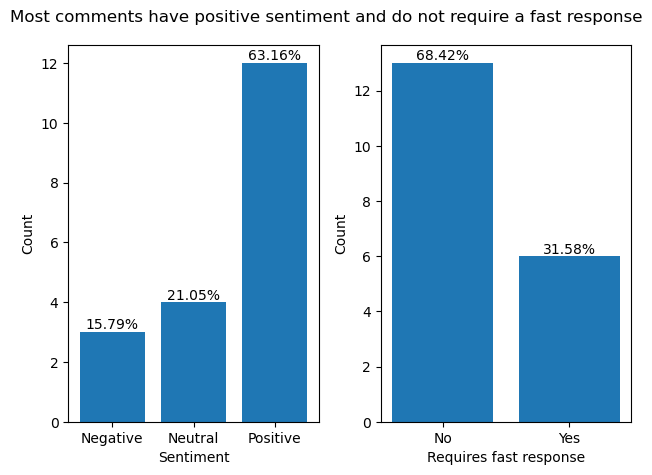

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_proportions(sentiment_data, respond_data):
    # Count the occurrences of each class for sentiment_data
    sentiment_class_counts = sentiment_data.value_counts().sort_index()
    sentiment_total = sentiment_class_counts.sum()
    sentiment_class_proportions = sentiment_class_counts / sentiment_total * 100

    # Count the occurrences of each class for respond_data
    respond_class_counts = respond_data.value_counts().sort_index()
    respond_total = respond_class_counts.sum()
    respond_class_proportions = respond_class_counts / respond_total * 100

    # Create the figure with subplots
    fig, axs = plt.subplots(1, 2)

    # Bar chart for sentiment_data
    x_sentiment = np.array(sentiment_class_counts.index)
    y_sentiment = np.array(sentiment_class_counts.values)
    axs[0].bar(x_sentiment, y_sentiment)

    axs[0].set_xlabel("Sentiment")
    axs[0].set_ylabel("Count")
    axs[0].set_xticks([-1, 0, 1])
    axs[0].set_xticklabels(["Negative", "Neutral", "Positive"])

    # Add percentage labels to each bar in the Sentiment Class Proportions plot
    for i, proportion in enumerate(sentiment_class_proportions.values):
        axs[0].text(x_sentiment[i], y_sentiment[i], f"{proportion:.2f}%", ha="center", va="bottom", color="black")

    # Bar chart for respond_data
    x_respond = np.array(respond_class_counts.index)
    y_respond = np.array(respond_class_counts.values)
    axs[1].bar(x_respond, y_respond)

    axs[1].set_xlabel("Requires fast response")
    axs[1].set_ylabel("Count")
    axs[1].set_xticks([0, 1])
    axs[1].set_xticklabels(["No", "Yes"])

    # Add percentage labels to each bar in the Respond Class Proportions plot
    for i, proportion in enumerate(respond_class_proportions.values):
        axs[1].text(x_respond[i], y_respond[i], f"{proportion:.2f}%", ha="center", va="bottom", color="black")

    # Set the figure title
    fig.suptitle("Most comments have positive sentiment and do not require a fast response")

    # Adjust layout
    plt.tight_layout()

    # Show the figure
    plt.show()

plot_class_proportions(sentiment_hl_dict, respond_hl_dict)

From the bar chart above, you see that most comments (63.16%) have positive sentiment and that most comments (68.42%) do not require a fast response.


### Sentiment Task
For the basic sentiment analysis task, ChatGPT had a 73.7% accuracy: 5 out of 18 of its classifications differed from mine (though to be fair, not all comments fell neatly into one bucket).

This metric may seem okay at first, but looking more closely at the results, you can see that in all but 2 of the 19 cases, ChatGPT rated the sentiment as "positive". Based on my "ground-truth" labelling, simply guessing "positive" sentiment to every comment would have been correct 63% of the time without a need to read the text. This means that ChatGPT may have lacked:
* the sensitivity to detect messages of negative sentiment.
* the ability to differentiate between neutral and positive sentiment.

Accuracy of GPT model for "sentiment": 0.7368421052631579


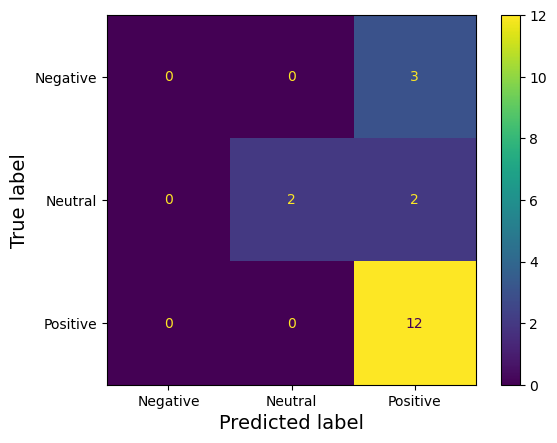

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def evaluate_GPT_results(results_df, GPT_label_column, human_labels):
    """
    Determine the accuracy of the GPT model by comparing its predictions to the human labels.

    Parameters:
        - results_df (pd.DataFrame): The dataframe containing the GPT predictions.
        - GPT_label_column (str): The column name containing the GPT predictions.
        - human_labels (pd.Series): The human labels.
    
    Returns:
        - accuracy (float): The accuracy of the GPT model.
        - DataFrame of GPT predictions and human labels.
        - confusion matrix (ConfusionMatrixDisplay): The confusion matrix of GPT predictions.

    """
    transformed_df = pd.DataFrame()
    if GPT_label_column == 'respond':
        transformed_df['GPT_label'] = results_df[GPT_label_column].apply(lambda x: 1 if x == 'Yes' else 0)
        cm_display_labels = ['No', 'Yes']
    else: 
        transformed_df['GPT_label'] = results_df[GPT_label_column].apply(lambda x: 1 if x == 'Positive' else -1 if x == 'Negative' else 0)
        cm_display_labels = ['Negative', 'Neutral', 'Positive']
    transformed_df['human_label'] = human_labels
    transformed_df['wrong_prediction'] = transformed_df['GPT_label'] != transformed_df['human_label']
    transformed_df['wrong_prediction'] = transformed_df['wrong_prediction'].apply(lambda x: 'Yes' if x else '')
    accuracy = accuracy_score(transformed_df['human_label'], transformed_df['GPT_label'])
    print(f'Accuracy of GPT model for "{GPT_label_column}": {accuracy}')
    fig, ax = plt.subplots(nrows=1, ncols=1)
    # ax = ax.flatten()
    cm = ConfusionMatrixDisplay.from_predictions(
        transformed_df['human_label'], transformed_df['GPT_label'], ax=ax,
        display_labels=cm_display_labels);
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    return accuracy, transformed_df, fig

cm_dict = dict()
accuracy_dict = dict()
transformed_df_dict = dict()
  
accuracy_dict[iteration], transformed_df_dict[iteration], cm_dict[iteration] = evaluate_GPT_results(
    results_dict[iteration], 'sentiment', sentiment_hl_dict);

In [ ]:
transformed_df_dict[iteration]

,GPT_label,human_label,wrong_prediction
0,1,1,
1,1,1,
2,1,-1,Yes
3,1,-1,Yes
4,1,1,
5,1,1,
6,1,0,Yes
7,1,-1,Yes
8,0,0,
9,1,1,


Below are the texts for which ChatGPT and I had different sentment ratings. It's hard to know whether the incorrect classifications were due to a general bias towards positive labelling or a lack of understanding about what people generally want when it comes to health/fitness.

In [21]:
def create_df_from_response(response):
    """
    Convert the response into a dataframe and strip white spaces at the start and end of text.
    """
    df = pd.DataFrame(response).transpose()
    for column in df.columns:
        df[column] = df[column].str.strip().str.replace('\n', ' ')
        df[column] = df[column].str.strip().str.replace('YOU:', '[YOU]')
        df[column] = df[column].str.strip().str.replace('MEMBER:', '[MEMBER]')
    return df


results_dict = {iteration: create_df_from_response(response_dict[iteration])}
results_dict[iteration].loc[[2, 3, 6, 7, 18], ['text', 'sentiment']]

,text,sentiment
2,"[YOU] Hey @everyone Throw me some questions for our live training tomorrow? Nutrition, exercise, weight loss etc. anything you need to know - that’s what I’m here for [MEMBER] Need some tips for tightening tummy … lost 7kg in 3 months but now got stuck in same weight for more than 2 weeks … what do I need to change??",Positive
3,[YOU] @everyone can you please send me some questions for our live training Thursday! Last weeks questions were great! Remember I’m trying to help you all as much as possible so use this opportunity 👌 [MEMBER] Did my measurements today and although my chest and hips seem to be coming down my stomach seems to be going up 😳 what am I doing wrong.,Positive
6,"[YOU] ‘I’ll never get results like her’ Do you find yourself thinking or saying that? If you do - you’re not alone!!!! This is something I hear REGULARLY! It starts with something like ‘Yea, but I can’t… The reality is the women’s results that I post are EXACTLY like you. ✅They are real women yielding real results. ✅They are busy - just like you! ✅They are mothers - just like you! ✅They face the same struggles - just like you! So what is the REAL difference between them and you? ✔️ They believe they can do it and then act. It’s honestly that simple. They are the women who decided to take action. While you’re still making excuses - they’re working on themselves for themselves ❤️ So next time you see a transformation photo and think ‘Good for them but that will never be me…’ Sam thought exactly the same before she decided to take action. She’s now almost a stone down, with more energy and happier than ever 🙏 If you’re ready for your own transformation - click the link in my bio to submit your waitlist application ✌️ [MEMBER] I have Crohn’s disease and I have an ulcer on my bowel and I’m only 39 and just have been told that I have neuropathic pain",Positive
7,"[YOU] @everyone I’m looking for some questions for Thursdays Q&A - remember all questions Re nutrition, fitness, motivation, mindset are relevant 🙌 [MEMBER] How to gain more visible leg muscle and bigger glutes. I am eating lots and training hard so not sure what the issue is lol",Positive
18,"[YOU] Ah but it’s just a glass of wine…. It’s just one beer? But is it though? Remember, it’s the accumulation of anything that is the problem. It’s never just one day or one drink. The same way one salad or one workout won’t make you healthy - it’s the accumulation over time. Is alcohol disrupting your routine? Is it causing you to miss every Monday? Is it causing poor food choices every Sunday? One thing I can tell you for certain is it’s negatively impacting your sleep and your metabolic function - even just one glass 🙈. I’m sorry to be the bearer of bad news…. And btw this is not coming from a pioneer…. I’ve been there. I’ve seen the implications it’s had not just on my goals but on my mental health and relationships…. That’s why I’ve reduced my frequency. Frequency is important. You might just think it’s one drink every other night… but when you accumulate the negative affects it has, you’ll understand that frequency matters. #alcohol #isalcoholworthit #onlinecoach #fitnesscoach #transformation #realresults #realpeople #nutritionist #realnutrition [MEMBER] Vicious 🤣",Positive


### Respond Task
ChatGPT I had better agreement when it came to advising whether or not the Facebook group admin should quickly respond to a given comment: We agreed on all but one comment, resulting in a 94.7% accuracy rating for ChatGPT.

Accuracy of GPT model for "respond": 0.9473684210526315


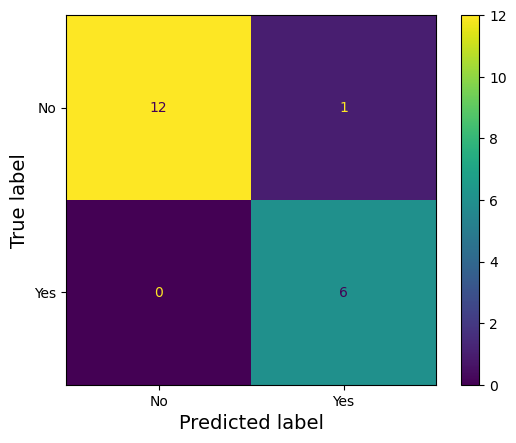

In [ ]:
accuracy_dict[iteration], transformed_df_dict[iteration], cm_dict[iteration] = evaluate_GPT_results(
    results_dict[iteration], 'respond', respond_hl_dict);

In [ ]:
transformed_df_dict[iteration]

,GPT_label,human_label,wrong_prediction
0,0,0,
1,0,0,
2,1,1,
3,1,1,
4,0,0,
5,0,0,
6,1,1,
7,1,1,
8,1,1,
9,0,0,


Below is the one case where ChatGPT and I didn't agree in relation to the "respond" task.

In [85]:
results_dict[iteration].loc[17:17, ['text', 'respond']]

,text,respond
17,[YOU] @everyone I’m sure you’ve heard me harp on about calories time in time out - well I’d like to help you ladies understand how to calculate your calories - I’ve derived this tool for you and together I’m hopeful I can help you achieve your goals through knowledge and education ❤️😊 (p.s exsisting clients I already do this calculation for you so no need to download this ✌️) [MEMBER] Thank you 🙂,Yes


Sure, it would be nice to respond with something along the lines of "you're welcome", but this was not crucial as indicated the context provided in the prompt:
> You aim to respond quickly to comments by group members if they request information, express a desire to improve their fitness, have health conditions or injuries, or express dissatisfaction with their current fitness.

### Emotion Detection
ChatGPT performed decently a lot of the time when asked to interpret emotion from text, but seems to take words literally, missing subtle nuances. For example, take text #18:

**text:**
> [YOU] Ah but it’s just a glass of wine…. It’s just one beer? But is it though? Remember, it’s the accumulation of anything that is the problem. It’s never just one day or one drink. The same way one salad or one workout won’t make you healthy - it’s the accumulation over time. Is alcohol disrupting your routine? Is it causing you to miss every Monday? Is it causing poor food choices every Sunday? One thing I can tell you for certain is it’s negatively impacting your sleep and your metabolic function - even just one glass 🙈. I’m sorry to be the bearer of bad news…. And btw this is not coming from a pioneer…. I’ve been there. I’ve seen the implications it’s had not just on my goals but on my mental health and relationships…. That’s why I’ve reduced my frequency. Frequency is important. You might just think it’s one drink every other night… but when you accumulate the negative affects it has, you’ll understand that frequency matters. #alcohol #isalcoholworthit #onlinecoach #fitnesscoach #transformation #realresults #realpeople #nutritionist #realnutrition [MEMBER] Vicious 🤣	

**ChatGPT response:** Frustration


In [19]:
results_dict[iteration].loc[18:18, ['text', 'emotions']]

,text,emotions
18,"[YOU] Ah but it’s just a glass of wine…. It’s just one beer? But is it though? Remember, it’s the accumulation of anything that is the problem. It’s never just one day or one drink. The same way one salad or one workout won’t make you healthy - it’s the accumulation over time. Is alcohol disrupting your routine? Is it causing you to miss every Monday? Is it causing poor food choices every Sunday? One thing I can tell you for certain is it’s negatively impacting your sleep and your metabolic function - even just one glass 🙈. I’m sorry to be the bearer of bad news…. And btw this is not coming from a pioneer…. I’ve been there. I’ve seen the implications it’s had not just on my goals but on my mental health and relationships…. That’s why I’ve reduced my frequency. Frequency is important. You might just think it’s one drink every other night… but when you accumulate the negative affects it has, you’ll understand that frequency matters. #alcohol #isalcoholworthit #onlinecoach #fitnesscoach #transformation #realresults #realpeople #nutritionist #realnutrition [MEMBER] Vicious 🤣",Frustration


The literal meaning of "vicious" has a negative tone, but in this context, it is evident that the commenter is joking: They don't actually think that the person who wrote the post is mean, just that the poster is reminding them about the unfortunate truth about something people enjoy.


Here's another example where ChatGPT was likely wrong about the main emotion:

In [18]:
results_dict[iteration].loc[5:5, ['text', 'emotions']]

,text,emotions
5,[YOU] Greetings team from Airlie Beach 👋 Reminder there will be no weekly live training next week as I am on holidays 🙏 I’m curious - have you any holidays planned this year? [MEMBER] You are less than 2 hours away from where I am thats so cool I love airlie beach just never find the time to go there anymore,Disappointment


If the comment had simply read "I love airlie beach just never find the time to go there anymore", then it would be reasonable to describe the commenter's main emotion as "disappointment". However, in this case, this line was more likely an after thought; the commenter was likely just noting a shared interest with the person who wrote the post.

# 4. Conclusion and Possible Future Directions
ChatGPT did a decent job at detecting sentiment and emotions, but had difficulty with discerning the meaning behind the words. However, it performed very well when given the specific task of determining whether or not the Facebook group administrator should respond to a comment. Perhaps ChatGPT can be most helpful when given sufficient context: The prompts for the sentiment and emotion tasks were not linked to a clear intent, unlike the "respond" task.

This was a fun proof-of-concept experiment to see if ChatGPT could be a good alternative to deploying a trained machine learning model. Based on these results, next time I would reflect more deeply about what I'd like ChatGPT to help me with and refine the work flow accordingly. Pragmatically, the low-hanging fruit would be to compare the results of different prompts.

Given the unbalanced data set, I would use different evaluation metrics depending on the specific intent of the work flow. For example:
* If I want a work flow that would be best at detecting negative sentiment/emotions so I can identify dissatisfied members/customers, I would likely use recall (sensitivity) as my evaluation metric, since there are fewer negative comments than positive.
* If I was looking for comments with highest level of excitement or gratitude so I can identify a handful of the biggest fans, I would consider using precision as my evaluation metric.

Of course, just because you CAN automate something, doesn't mean you should. Automations are most useful when there are too many messages than there are human resources. As these results show, ChatGPT is not a replacement for humans when it comes to understanding humans.

#